# Chapter 4 Topic Modeling 

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Building a topic model 

In [2]:
!wget http://www.cs.columbia.edu/~blei/lda-c/ap.tgz
!tar xzf ap.tgz

--2021-04-09 04:29:44--  http://www.cs.columbia.edu/~blei/lda-c/ap.tgz
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2925653 (2.8M) [application/x-gzip]
Saving to: ‘ap.tgz’

ap.tgz              100%[===================>]   2.79M  2.21MB/s    in 1.3s    

2021-04-09 04:29:46 (2.21 MB/s) - ‘ap.tgz’ saved [2925653/2925653]



In [5]:
from gensim import corpora, models

In [6]:
corpus = corpora.BleiCorpus('./ap/ap.dat',
                            './ap/vocab.txt')

In [80]:
model = models.ldamodel.LdaModel(corpus, 
                                 num_topics=100,
                                 id2word=corpus.id2word)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [12]:
doc = corpus.docbyoffset(0)
len(doc)

186

In [13]:
topics = model[doc]
print(len(topics))
print(topics)

11
[(2, 0.07874746), (6, 0.04797098), (12, 0.01739159), (13, 0.03402003), (15, 0.013346842), (16, 0.061924398), (40, 0.27927586), (48, 0.06481411), (53, 0.04821961), (55, 0.03913494), (63, 0.26857436)]


In [17]:
num_topics_used = [len(model[doc]) for doc in corpus]

In [131]:
len(num_topics_used)

2246

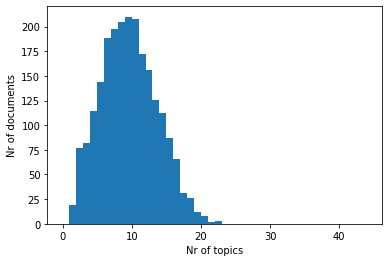

In [42]:
plt.hist(num_topics_used, np.arange(45))
plt.ylabel('Nr of documents')
plt.xlabel('Nr of topics')
plt.show()

In [44]:
model2 = models.ldamodel.LdaModel(corpus,
                                 num_topics=100,
                                 id2word=corpus.id2word,
                                 alpha=1)


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [46]:
num_topics_used2 = [len(model2[doc]) for doc in corpus]

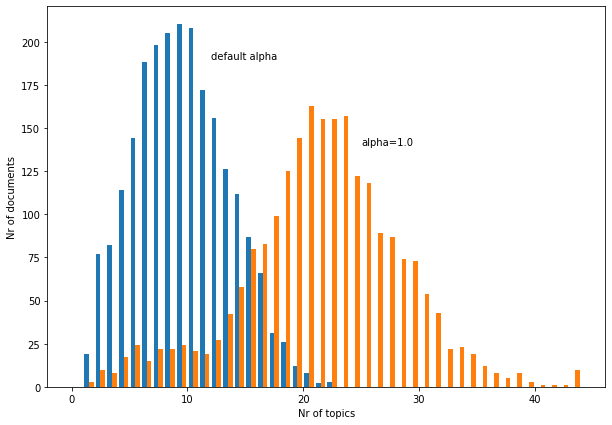

In [117]:
fig, ax = plt.subplots(figsize=(10,7))
ax.hist([num_topics_used, num_topics_used2], np.arange(45))

ax.text(12, 190, 'default alpha')
ax.text(25, 140, 'alpha=1.0')
plt.ylabel('Nr of documents')
plt.xlabel('Nr of topics')
plt.show()

## Comparing documents by topics

In [87]:
from gensim import matutils

In [96]:
topics = matutils.corpus2dense(model[corpus],
                               num_terms=model.num_topics)
topics.shape

/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


(100, 2246)

In [93]:
len(corpus)

2246

In [94]:
from scipy.spatial import distance

In [95]:
pairwise = distance.squareform(distance.pdist(topics))
pairwise.shape

(100, 100)

In [97]:
largest = pairwise.max()
for ti in range(len(topics)):
    pairwise[ti,ti] = largest+1

In [98]:
def closest_to(doc_id):
    return pairwise[doc_id].argmin()

In [113]:
closest_to(1)

94

## Modeling the whole of Wikipedia

In [147]:
#!/bin/sh
!wget http://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz3

--2021-04-09 06:06:26--  http://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.7, 2620:0:861:1:208:80:154:7
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.7|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2 [following]
--2021-04-09 06:06:27--  https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18416049294 (17G) [application/octet-stream]
Saving to: ‘enwiki-latest-pages-articles.xml.bz2’

enwiki-latest-pages 100%[===================>]  17.15G  4.75MB/s    in 64m 30s 

2021-04-09 07:10:58 (4.54 MB/s) - ‘enwiki-latest-pages-articles.xml.bz2’ saved [18416049294/18416049294]



In [156]:
!ls /content/

ap  ap.tgz  enwiki-latest-pages-articles.xml.bz2  sample_data  wiki_en_output


In [161]:
!python -m gensim.scripts.make_wiki enwiki-latest-pages-articles.xml.bz2 /content/wiki_en_output

In [158]:
import logging, gensim

In [159]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)


In [163]:
id2word = gensim.corpora.Dictionary.load_from_text('wiki_en_output_wordids.txt')
mm = gensim.corpora.MmCorpus('wiki_en_output_tfidf.mm')

In [164]:
model = gensim.models.ldamodel.LdaModel(corpus=mm,
                                        id2word=id2word,
                                        num_topics=100,
                                        update_every=1,
                                        chunksize=10000,
                                        passes=1)


In [166]:
model.save('wiki_lda.pkl')

2021-04-09 10:41:00,860 : INFO : saving LdaState object under wiki_lda.pkl.state, separately None
2021-04-09 10:41:00,925 : INFO : saved wiki_lda.pkl.state
2021-04-09 10:41:00,942 : INFO : saving LdaModel object under wiki_lda.pkl, separately ['expElogbeta', 'sstats']
2021-04-09 10:41:00,944 : INFO : storing np array 'expElogbeta' to wiki_lda.pkl.expElogbeta.npy
2021-04-09 10:41:00,964 : INFO : not storing attribute id2word
2021-04-09 10:41:00,966 : INFO : not storing attribute state
2021-04-09 10:41:00,969 : INFO : not storing attribute dispatcher
2021-04-09 10:41:00,986 : INFO : saved wiki_lda.pkl


In [167]:
model = gensim.models.ldamodel.LdaModel.load('wiki_lda.pkl')

2021-04-09 10:41:19,306 : INFO : loading LdaModel object from wiki_lda.pkl
2021-04-09 10:41:19,328 : INFO : loading expElogbeta from wiki_lda.pkl.expElogbeta.npy with mmap=None
2021-04-09 10:41:19,336 : INFO : setting ignored attribute id2word to None
2021-04-09 10:41:19,338 : INFO : setting ignored attribute state to None
2021-04-09 10:41:19,341 : INFO : setting ignored attribute dispatcher to None
2021-04-09 10:41:19,344 : INFO : loaded wiki_lda.pkl
2021-04-09 10:41:19,347 : INFO : loading LdaState object from wiki_lda.pkl.state
2021-04-09 10:41:19,378 : INFO : loaded wiki_lda.pkl.state


In [170]:
topics = matutils.corpus2dense(model[doc],
                               num_terms=model.num_topics)

In [171]:
lens = (topics > 0).sum(axis=0)
print(np.mean(lens))

9.255565449688335


In [172]:
print(np.mean(lens <= 10))

0.6264470169189671


In [177]:
weights = topics.sum(axis=0)
words = model.show_topic(weights.argmax(), 64)

In [182]:
words = model.show_topic(weights.argmin(), 64)
# weights.argmin()